In [1]:
%pylab inline

import pandas as pd
import nltk
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import f1_score, jaccard_score

import dill as pickle
import pyLDAvis

Populating the interactive namespace from numpy and matplotlib


In [4]:
# We are using the datas with only 296 tags
data = pd.read_csv('data_51k_296_tags.csv', encoding='utf8')

In [5]:
data.shape

(51427, 4)

In [6]:
df = data[['Body', 'tags_clean']]
df.isnull().sum()

Body          0
tags_clean    0
dtype: int64

In [ ]:
#---------------------#

In [ ]:
# Cleaning

In [25]:
def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

In [26]:
def comment_to_list_of_words(nlp, comment):
    # Delete non alphabetical character
    text = cleanhtml(comment.replace('\n',''))

    doc = nlp(text)
    tokenizer = []
    for token in doc:
        if(
            token.is_stop == False 
            and token.is_alpha == True
            and (
                token.pos_ == 'NOUN'
                or token.pos_ == 'PROPN'
                or token.pos_ == 'VERB'
                )
            and (
                token.shape_ != 'x'
                or token.shape_ != 'X'
                )
            ):
            tokenizer.append(token.lemma_.lower())

    if len(tokenizer) > 2:
        return ' '.join(tokenizer)

In [ ]:
# disabling Named Entity Recognition for speed
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

txt = [comment_to_list_of_words(nlp, doc) for doc in df['Body']]

df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()

In [4]:
# In order to run the code one more time
# we are saving / loading the cleaned datas

# df_clean.to_csv('df_clean_51k.csv')
# df_clean = pd.read_csv('df_clean_51k.csv')
# df_clean.tags_clean = df_clean.tags_clean.apply(lambda x: x.replace('[', '').replace(']', '').replace("'", '').replace(" ", '').split(','))

In [5]:
df_clean.head()

,Unnamed: 0,body_clean,title_clean,tags_clean,Title_and_Body_cleaned
0,0,want series d print beginner output contain va...,postgre series print,"[sql, postgresql]",postgre series print want series d print begin...
1,1,diff use content format change tweak remove bo...,apply patch git construct,[git],apply patch git construct diff use content for...
2,2,thank letter write take code capitalize sort w...,letter base capital sort list function,[python],letter base capital sort list function thank l...
3,3,company repos employee change work ask account...,github work profile contribution,"[git, github]",github work profile contribution company repos...
4,4,hour example index value throw nest column ass...,dataframe datetime value determine pair column,"[python, pandas, numpy]",dataframe datetime value determine pair column...


In [ ]:
#---------------------#

In [6]:
# tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=0.01, ngram_range=(1, 2))

x_tfidf = tfidf_vectorizer.fit_transform(df_clean.Title_and_Body_cleaned)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

len(tfidf_feature_names)

701

In [66]:
# Visualization of some deleted words
list(tfidf_vectorizer.stop_words_)[5:21]

['マミムメモ たちつてと',
 'merge index',
 'constructor nature',
 'plane ship',
 'myinfo',
 'stop jvm',
 'throw relate',
 'key match',
 'interview question',
 'exclude actionmailer',
 'choice user',
 'app androidmanifest',
 'maingit',
 'configuration dockerfile',
 'itershape',
 'allquestionsandanswersclass']

In [ ]:
'''
TF-IDF deleted some special words,
like foreign word (マミムメモ たちつてと)
or sentences without space (allquestionsandanswersclass).
'''

In [83]:
df_tmp = pd.DataFrame({
    'features': tfidf_feature_names,
    'tf-idf': tfidf_vectorizer.idf_
})

df_tmp.sort_values(by='tf-idf', ascending=False)[:10]

,features,tf-idf
497,reduce,5.602156
172,developer,5.602156
656,usage,5.602156
322,invoke,5.600216
180,disable,5.598280
90,cloud,5.598280
558,set code,5.598280
549,security,5.598280
85,cli,5.598280
112,compose,5.594419


In [88]:
df_tmp.sort_values(by='tf-idf', ascending=True)[:10]

,features,tf-idf
636,try,1.884236
91,code,2.063309
675,want,2.182489
692,work,2.196954
524,return,2.276282
657,use,2.332919
204,error,2.470299
679,way,2.519712
138,create,2.567390
665,value,2.574229


In [ ]:
'''
Thnaks to th TF-IDF algorithm, some words (cloud, security, etc)
are not forgotten at the expense of more frequent words (try, code, want, etc).
'''

In [ ]:
#---------------------#

In [ ]:
# Number of topics to find

In [35]:
liste_perplexity = []
liste_nbr_topics = []
liste_log_likelihood = []
for i in range(5, 30, 5):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, learning_method='online', learning_offset=50, random_state=0)
    lda.fit(x_tfidf.todense())

    liste_nbr_topics.append(i)
    liste_perplexity.append(lda.perplexity(x_tfidf))
    liste_log_likelihood.append(lda.score(x_tfidf))

5
10
15
20
25


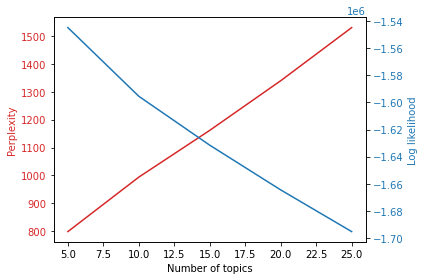

In [36]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of topics')
ax1.set_ylabel('Perplexity', color=color)
ax1.plot(liste_nbr_topics, liste_perplexity, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Log likelihood', color=color)
ax2.plot(liste_nbr_topics, liste_log_likelihood, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
'''
We will set Number of topics to 15.
'''

In [ ]:
#---------------------#

In [ ]:
# LDA trainning

In [7]:
# tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=0.01, ngram_range=(1, 2))

x_tfidf = tfidf_vectorizer.fit_transform(df_clean.Title_and_Body_cleaned)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

len(tfidf_feature_names)

701

In [ ]:
# Saving tfidf
with open('../flask_api_git/models/lda/' + 'tfidf_vectorizer_lda_v1', 'wb') as file:
	pickle.dump(tfidf_vectorizer, file)

# Saving tfidf_feature_names
with open('../flask_api_git/models/lda/' + 'tfidf_lda_feature_names.pk', 'wb') as file:
	pickle.dump(tfidf_feature_names, file)

In [15]:
# Define Search Param
search_params = {'n_components': [10, 15, 20], 'learning_decay': [.5, .7, .9], 'learning_offset': [10, 50, 100]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online', random_state=0)

# Init Grid Search Class
model = GridSearchCV(
    lda,
    param_grid=search_params
    )

# Do the Grid Search
# In order to get fast, we are using few rows of the dataset
model.fit(x_tfidf[:5000])

GridSearchCV(estimator=LatentDirichletAllocation(learning_method='online',
                                                 random_state=0),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_offset': [10, 50, 100],
                         'n_components': [10, 15, 20]})

In [16]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(x_tfidf[:10000]))

Best Model's Params:  {'learning_decay': 0.7, 'learning_offset': 100, 'n_components': 15}
Best Log Likelihood Score:  -35235.11998742402
Model Perplexity:  1407.4388831913398


In [ ]:
#---------------------#

In [ ]:
# The LDA we will use in the API
# Here, it's fit with all the datas

In [8]:
lda = LatentDirichletAllocation(n_components=15, learning_method='online', learning_decay=0.7, learning_offset=100, random_state=0)
lda.fit(x_tfidf)

LatentDirichletAllocation(learning_method='online', learning_offset=100,
                          n_components=15, random_state=0)

In [28]:
# Saving lda:
filename = 'model_lda_v1.pk'
with open('../flask_api_git/models/lda/' + filename, 'wb') as file:
	pickle.dump(lda, file)

In [9]:
def topic_table(n_top_words, feature_names, model):
  topics = {}
  for i, topic_vec in enumerate(model.components_):
    topic_descr = ''
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
      topic_descr = topic_descr + feature_names[fid] + " "
    topics[i] = topic_descr
  return pd.DataFrame({'Top_Topic_Terms': topics})

In [10]:
# Label topics with top 5 terms
topic_df = topic_table(5, tfidf_feature_names, lda)
topic_df

,Top_Topic_Terms
0,request api async await return
1,type function class object return
2,column dataframe row value df
3,git github commit branch repository
4,react component render const gt
5,model tensorflow difference use import
6,run error build file docker
7,string file print output code
8,plot date month day year
9,view swiftui button android var


In [10]:
dash = pyLDAvis.sklearn.prepare(lda, x_tfidf, tfidf_vectorizer, mds='tsne')

In [11]:
# Saving the dash
pyLDAvis.save_html(dash, 'lda_topics_html.html')

In [38]:
pyLDAvis.display(dash)

In [ ]:
#---------------------#

In [292]:
# NMF algorithm
nmf = NMF(n_components=15, random_state=0, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(x_tfidf)

NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=15, random_state=0)

In [11]:
# Label topics with top 5 terms
topic_df_nmf = topic_table(5, tfidf_feature_names, nmf)

In [41]:
pyLDAvis.display(pyLDAvis.sklearn.prepare(nmf, x_tfidf, tfidf_vectorizer, mds='tsne'))

In [ ]:
#---------------------#

In [ ]:
# Test the tags prediction with some sentences

In [109]:
new_review1 = ['Hello! I want to create a model, which can give the tags of a sentence or question. Besides, I have to try both supervised and unsupervised machine learning algorithms. Do you know some python librairies, which can help building fast models?']

new_review2_title = ["Finding duplicate values in a SQL table"]
new_review2 = ["It's easy to find duplicates with one field. So if we have a table. This query will give us John, Sam, Tom, Tom because they all have the same email. However, what I want is to get duplicates with the same email and name. That is, I want to get 'Tom', 'Tom'. The reason I need this: I made a mistake, and allowed to insert duplicate name and email values. Now I need to remove/change the duplicates, so I need to find them first."]

new_review3_title = ["How to make several plots on a single page using matplotlib?"]
new_review3 = ["I have written code that opens 16 figures at once. Currently they all open as separate graphs. I'd like them to open all on the same page. Not the same graph. I want 16 separate graphs on a single page/window. Also for some reason the format of the numbins and defaultreallimits doesn't hold past figure 1. Do I need to use the subplot command? I don't understand why I would have to but can't figure out what else I would do?"]

new_review4 = ['is it possible to increase the ram in google colab with another way?']

In [113]:
def topics(lda, tfidf_vectorizer, n_top_words):

    topics = {}
    for i, topic_vec in enumerate(lda.components_):
        topic_descr = ''
        for j in topic_vec.argsort()[-1:-n_top_words-1:-1]:
            topic_descr = topic_descr + tfidf_vectorizer.get_feature_names()[j] + " "
            topics[i] = topic_descr

    topic_df = pd.DataFrame({'Top_Topic_Terms': topics})

    return(topic_df)

In [114]:
# Print the tags for a question
def tag_for_text(text, lda, tfidf_vectorizer, n_top_words):

    return(topics(lda, tfidf_vectorizer, n_top_words)['Top_Topic_Terms'][
        lda.transform(tfidf_vectorizer.transform(text)).argsort(axis=1)[:,-1][0]
    ].split())

In [22]:
texts = [new_review1, new_review2, new_review3, new_review4]

for i in range(len(texts)):

    print('text ' + str(i + 1) + ' - LDA Tags:')
    print(tag_for_text(texts[i], lda, tfidf_feature_names, 5))

    if(i < len(texts) - 1):
        print('\n')

text 1 - LDA Tags:
['model', 'tensorflow', 'difference', 'use', 'import']


text 2 - LDA Tags:
['query', 'table', 'select', 'database', 'field']


text 3 - LDA Tags:
['file', 'html', 'page', 'code', 'script']


text 4 - LDA Tags:
['model', 'tensorflow', 'difference', 'use', 'import']


In [23]:
for i in range(len(texts)):

    print('text ' + str(i + 1) + ' - NMF Tags:')
    print(tag_for_text(texts[i], nmf, tfidf_feature_names, 5))

    if(i < len(texts) - 1):
        print('\n')

text 1 - NMF Tags:
['way', 'use', 'know', 'example', 'time']


text 2 - NMF Tags:
['datum', 'user', 'request', 'api', 'database']


text 3 - NMF Tags:
['way', 'use', 'know', 'example', 'time']


text 4 - NMF Tags:
['way', 'use', 'know', 'example', 'time']


In [ ]:
'''
The lda seems have better predictions.
Besides, we can evaluate a LDA quality thanks to
perplexity or log_likelihood.
But, this is not possible with NMF.

That's why, we will not use a NMF model for the API.
We will use a LDA model.
'''

In [ ]:
#---------------------#

In [ ]:
# Metrics for LDA

In [ ]:
# We will first compare the tags with those given by the datas
# (column 'tags_clean' of the dataFrame df_clean)

In [313]:
def f1_jaccard_scores(x, y, model_lda, tfidf, mlb):

    liste_result_y_pred_lda = []
    for j in range(len(x)):
        liste_result_y_pred_lda.append(
            mlb.transform([set(tag_for_text([x[j]], model_lda, tfidf, 5))])[0]
        )

    liste_result_y_true = []
    for j in range(len(y)):
        liste_result_y_true.append(
            mlb.transform([set(y[j])])[0]
        )
    
    print("LDA:")
    print("F1 score (weighted)      = {:.2f}".format(f1_score(liste_result_y_true, liste_result_y_pred_lda, average='weighted')))
    print("Jaccard score (weighted) = {:.2f}".format(jaccard_score(liste_result_y_true, liste_result_y_pred_lda, average='weighted')))

In [137]:
# Target (tags) encoding
# The vocabulary, i.e. the classes,
# is the tags + all the tags given by the LDA topics
mlb = MultiLabelBinarizer()
mlb.fit(pd.concat([
    df_clean['tags_clean'],
    topics(model_lda, tfidf_lda, 5)['Top_Topic_Terms'].apply(lambda x: x.split())
]))

# Target encoded decoding
le = LabelEncoder()
le.fit(mlb.classes_)

print(len(mlb.classes_))

344


In [311]:
# F1, jaccard -> average = weighted
test_size = 10000

f1_jaccard_scores(
    df_clean.Title_and_Body_cleaned[:test_size],
    df_clean.tags_clean[:test_size],
    lda,
    tfidf_vectorizer,
    mlb
)

LDA:
F1 score (weighted)      = 0.04
Jaccard score (weighted) = 0.03


In [ ]:
'''
The scores are low because the metrics look for an exact match
between y_pred and y_true.

Here, one should rather look for a similar meaning (semantic)
between each subject and each word in the dictionary.

In order to do this, we can imagine two methods:
    - the first one is to find those meanings manually.
    It could consume a lot of time to achieve this method.
    Besides, we have to interpret the meaning of each topic and each sentence.
    This could introduce a lot of mistakes.

    - the second one is to use some embedding methods as word2vec or doc2vec (gensim).
    But, we have to know how to configure the hyperparameters, how to train or fit these
    neural network algorithms.

Here, we would try the first method. But, we will only use 30 sentences.
It is just to have a trend.
'''

In [325]:
# Topics of the LDA algorithm
topics(lda, tfidf_vectorizer, 7)

,Top_Topic_Terms
0,request api async await return error response
1,type function class object return argument par...
2,column dataframe row value df panda datum
3,git github commit branch repository push master
4,react component render const gt gt const state
5,model tensorflow difference use import python ...
6,run error build file docker version project
7,string file print output code line word
8,plot date month day year min hour
9,view swiftui button android var app body


In [490]:
# How can we describe each topic
list_topics_name = [
    "issues with api",
    "define a function",
    "pandas dataFrame",
    "git & github",
    "component",
    "python, function, machine learning",
    "files or project errors",
    "strings",
    "time",
    "android function/app/design",
    "integers and array / line of code",
    "regex (to clean strings)",
    "read files or code with software as VSC",
    "sql",
    "css"
]

In [492]:
df_topics = pd.DataFrame({
    "topic_lda": list_topics_name
})

In [493]:
df_topics

,topic_lda
0,issues with api
1,define a function
2,pandas dataFrame
3,git & github
4,component
5,"python, function, machine learning"
6,files or project errors
7,strings
8,time
9,android function/app/design


In [489]:
# example of the first sentence
# we will have to find the correct topic with the tokens and the tags
# (given by the column 'tags_clean' of the dataFrame df_clean)
print(df_clean.Title_and_Body_cleaned[0])
print(df_clean.tags_clean[0])

postgre series print want series d print beginner output contain value postgres row number datum column table time
['sql', 'postgresql']


In [483]:
list_Topics_y_true = [13, 3, 5, 3, 2, 10, 0, 1, 6, 1, 1, 11, 10, 5, 5, 1, 6, 5, 0, 13, 1, 12, 0, 5, 10, 9, 1, 2, 2, 13]

In [487]:
# Create a list which contains the index of the topic
# for each sentence
# This index is predicted by the LDA algorithm

list_topics_y_pred = []
for i in range(30):
    list_topics_y_pred.append(
        lda.transform(
            tfidf_vectorizer.transform(
                [df_clean.Title_and_Body_cleaned[i]]
            )
        ).argsort(axis=1)[:,-1][0]
    )

In [488]:
print("LDA:")
print("F1 score (weighted)      = {:.2f}".format(f1_score(list_Topics_y_true, list_topics_y_pred, average='weighted')))
print("Jaccard score (weighted) = {:.2f}".format(jaccard_score(list_Topics_y_true, list_topics_y_pred, average='weighted')))

LDA:
F1 score (weighted)      = 0.35
Jaccard score (weighted) = 0.25


In [ ]:
'''
We know that these scores are only trends.
But it seems more usable than the previous results
(0.04 and 0.03 for F1 and Jaccar)

Now we can create a supervised algorithm and compare its results
with those trends.
'''